***
# <font color=red>Building a Classifier using AutoMLx</font>
<p style="margin-left:10%; margin-right:10%;"> <font color=teal>  </font></p>

***

## Overview of this Notebook

This notebook is an introduction to build a classifier using the Oracle AutoMLx tool for credit-g dataset. This dataset classifies people described by a set of attributes as good or bad credit risks. The dataset is a binary-class classification dataset, and more details about the dataset can be found at https://www.openml.org/search?type=data&sort=runs&status=active&id=31. We demonstrate the preliminary steps required to train a model with the Oracle AutoMLx tool. 

In this notebook we will walk through,
- Setup
- Load the credit-g Income dataset
- AutoML
    - Set the engine and deprecation warnings
    - Create an Instance of Oracle AutoMLx
    - Train a Model using AutoML
    - Analyze the AutoML optimization process

<a id='setup'></a>
## Setup

Basic setup for the Notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules.

Please select the conda envionment "automlx_p38_cpu_v5" before proceeding further. 

In [2]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

import automl
from automl import init

<a id='load-data'></a>
## Load the credit-g dataset
We start by reading in the dataset from OpenML.

In [3]:
dataset = fetch_openml(name='credit-g', as_frame=True)
df, y = dataset.data, dataset.target

Lets look at a few of the values in the data

In [4]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


We visualize the distribution of the target variable in the training data.

[Text(0, 0, '700'), Text(0, 0, '300')]

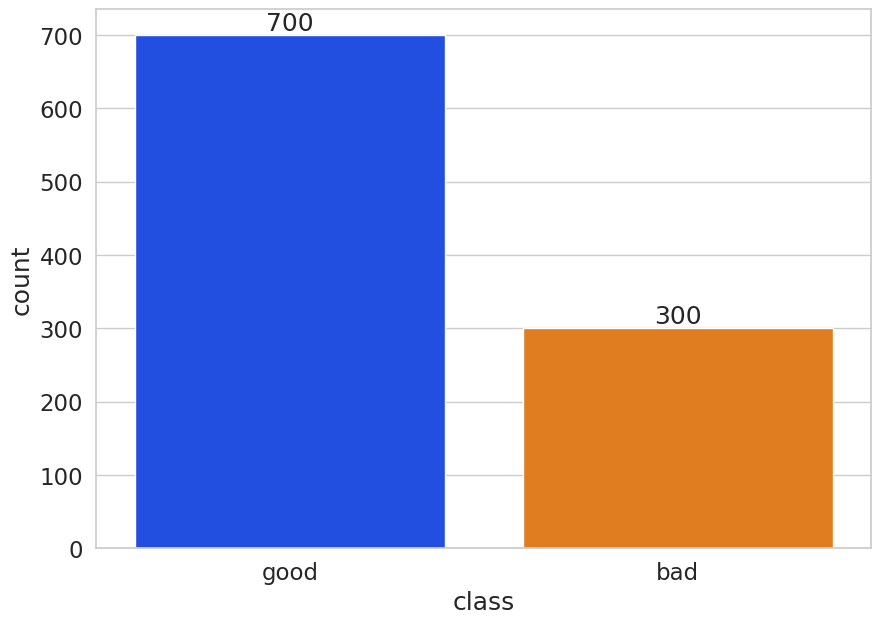

In [5]:
y_df = pd.DataFrame(y)
y_df.columns = ['class']

ax = sns.countplot(x="class", data=y_df)
ax.bar_label(ax.containers[0])

We now separate the predictions (`y`) from the training data (`X`) for both the training (80%) and test (20%) datasets. The training set will be used to create a Machine Learning model using AutoML, and the test set will be used to evaluate the model's performance on unseen data.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train.shape, X_test.shape

((800, 20), (200, 20))

<a id='AutoML'></a>
## AutoML

<a id='Engine'></a>
### Setting the engine and deprecation warnings
The AutoML pipeline offers the function `init`, which allows to initialize the parallelization engine. 

We will use `'local'` parallelization engine, which uses python's multiprocessing library for parallelism instead.

In [7]:
init(engine='local', check_deprecation_warnings=False)

[2023-11-10 03:28:43,989] [automl.xengine] Local ProcessPool execution (n_jobs=2)


<a id='provider'></a>
### Create an instance of Oracle AutoMLx

The Oracle AutoMLx solution provides a pipeline that automatically finds a tuned model given a prediction task and a training dataset. In particular it allows to find a tuned model for any supervised prediction task, e.g. classification or regression where the target can be binary, categorical or real-valued.

AutoML consists of five main modules: 
- **Preprocessing** : Clean, impute, engineer, and normalize features.
- **Algorithm Selection** : Identify the right classification algorithm -in this notebook- for a given dataset, choosing from amongst:
    - AdaBoostClassifier
    - DecisionTreeClassifier
    - ExtraTreesClassifier
    - TorchMLPClassifier
    - KNeighborsClassifier
    - LGBMClassifier
    - LinearSVC
    - LogisticRegression
    - RandomForestClassifier
    - SVC
    - XGBClassifier
    - GaussianNB
- **Adaptive Sampling** : Select a subset of the data samples for the model to be trained on.
- **Feature Selection** : Select a subset of the data features, based on the previously selected model.
- **Hyperparameter Tuning** : Find the right model parameters that maximize score for the given dataset. 

All these pieces are readily combined into a simple AutoML pipeline which automates the entire Machine Learning process with minimal user input/interaction.

<a id='default'></a>
### Train a model using AutoML

The AutoML API is quite simple to work with. We create an instance of the pipeline. Next, the training data is passed to the `fit()` function which executes the previously mentioned steps.

In [8]:
est = automl.Pipeline(task='classification')
est.fit(X_train, y_train)

[2023-11-10 03:28:45,737] [automl.pipeline] Random state (7) is used for model builds
[2023-11-10 03:28:45,751] [automl.pipeline] Dataset shape: (800, 20)
[2023-11-10 03:28:45,761] [automl.pipeline] Running Auto-Preprocessing
[2023-11-10 03:28:45,862] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (800, 40), cv: 5
[2023-11-10 03:28:46,467] [automl.pipeline] Running Model Selection
[2023-11-10 03:28:52,690] [automl.pipeline] Model Selection completed. Selected model: ['XGBClassifier']
[2023-11-10 03:28:52,691] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (800, 40), Valid Shape: None, CV: 5, Class counts: [241 559]
[2023-11-10 03:28:53,259] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (800, 40), Valid Shape: None, CV: [(640, 160), (640, 160), (640, 160), (640, 160), (640, 160)], Class counts: [241 559]
[2023-11-10 03:28:53,260] [automl.pipeline] Starting Feature Selection 0. Dataset Shape: (800, 40)
[2023-11-10 03:29:14,619] [aut

Pipeline(model_list=['DecisionTreeClassifier', 'ExtraTreesClassifier',
                     'GaussianNB', 'LGBMClassifier', 'LogisticRegression',
                     'RandomForestClassifier', 'SVC', 'XGBClassifier',
                     'TorchMLPClassifier', 'CatBoostClassifier'])

A model is then generated (`est`) and can be used for prediction tasks. We use the `f1_score` scoring metric to evaluate the performance of this model on unseen data (`X_test`).

In [9]:
y_pred = est.predict(X_test)
score_default = f1_score(y_test, y_pred, average='macro')
print(f'Score on test data : {score_default}')

Score on test data : 0.7516695191113796


<a id='analyze'></a>
### Analyze the AutoML optimization process

During the AutoML process, a summary of the optimization process is logged. It consists of:
- Information about the training data .
- Information about the AutoML Pipeline, such as:
    - Selected features that AutoML found to be most predictive in the training data;
    - Selected algorithm that was the best choice for this data;
    - Selected hyperparameters for the selected algorithm.

AutoML provides a `print_summary` API to output all the different trials performed.

In [10]:
est.print_summary()

Training Dataset size,"(800, 20)"
Validation Dataset size,None
CV,5
Optimization Metric,neg_log_loss
Selected Features,"Index(['checking_status_2', 'checking_status_3', 'checking_status_4', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status_2', 'personal_status_4', 'other_parties_2', 'residence_since', 'property_magnitude_4', 'age', 'other_payment_plans_2', 'housing_2', 'foreign_worker_2'], dtype='object')"
Selected Algorithm,XGBClassifier
Time taken,60.1606
Selected Hyperparameters,"{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.09999357749397217, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 3, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 7, 'reg_alpha': 0.22506130664508012, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}"
AutoML version,23.2.2
Python version,"3.8.16 (default, Jun 12 2023, 18:09:05) \n[GCC 11.2.0]"


Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage (GB)
XGBClassifier_HT,800,19,-0.5019,"{'booster': 'gbtree', 'learning_rate': 0.09999357749397217, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.22506130664508012, 'reg_lambda': 1}",0.3075,"(0.0, None)"
XGBClassifier_HT,800,19,-0.5019,"{'booster': 'gbtree', 'learning_rate': 0.09999357749397217, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.2249765300761397, 'reg_lambda': 1}",0.2884,"(0.0, None)"
XGBClassifier_HT,800,19,-0.5019,"{'booster': 'gbtree', 'learning_rate': 0.09999886159517773, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.2249765300761397, 'reg_lambda': 1}",0.3520,"(0.0, None)"
XGBClassifier_HT,800,19,-0.5019,"{'booster': 'dart', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.2249765300761397, 'reg_lambda': 1}",2.2310,"(0.0, None)"
XGBClassifier_HT,800,19,-0.5019,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.2249765300761397, 'reg_lambda': 1}",0.3026,"(0.0, None)"
...,...,...,...,...,...,...
XGBClassifier_HT,800,19,-0.6920,"{'booster': 'gbtree', 'learning_rate': 0.0001, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 50, 'reg_alpha': 0.0, 'reg_lambda': 5.623413251903491}",0.3024,"(0.0, None)"
XGBClassifier_HT,800,19,-0.6920,"{'booster': 'gbtree', 'learning_rate': 0.0001, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 50, 'reg_alpha': 0.0, 'reg_lambda': 5.6244132519034915}",0.2140,"(0.0, None)"
TorchMLPClassifier_AS,800,40,-0.7249,"{'activation': 'relu', 'class_weight': None, 'dropout': 0.1, 'l2_reg': 0.0, 'nr_layers': 1, 'nr_neurons': 100, 'optimizer': 'adam'}",2.4807,0.0
GaussianNB_AS,800,40,-1.4507,{},0.0342,0.0


We also provide the capability to visualize the results of each stage of the AutoML pipeline. 

<a id='algorithm-selection'></a>
#### Algorithm Selection

The plot below shows the scores predicted by Algorithm Selection for each algorithm. The horizontal line shows the average score across all algorithms. Algorithms below the line are colored turquoise, whereas those with a score higher than the mean are colored teal. Here we can see that the `XGBClassifier` achieved the highest predicted score (orange bar), and is chosen for subsequent stages of the Pipeline.

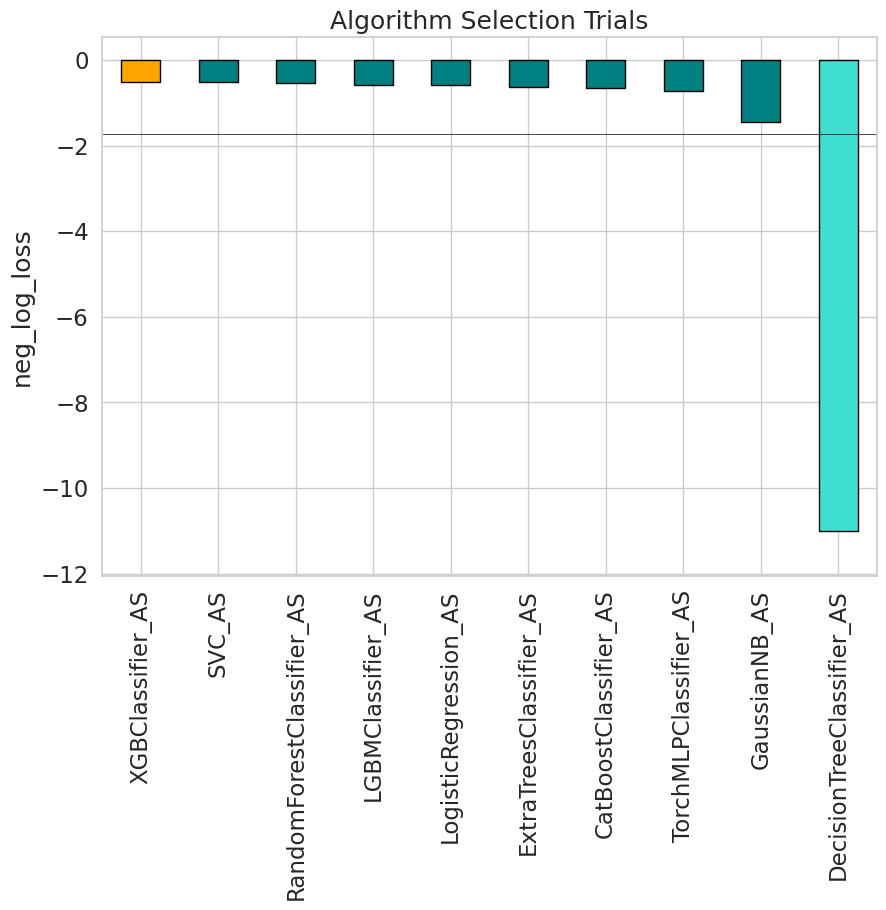

In [11]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = est.model_selection_trials_
colors = []
scores = [x[3] for x in trials]
models = [x[0] for x in trials]
y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)

for f in s.keys():
    if f == '{}_AS'.format(est.selected_model_):
        colors.append('orange')
    elif s[f] >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')
        

fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est.inferred_score_metric[0])
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()

<a id='adaptive-sampling'></a>
#### Adaptive Sampling

Following Algorithm Selection, Adaptive Sampling aims to find the smallest dataset sample that can be created without compromising validation set score for the chosen model (`XGBClassifier`). In this case, no subset is found to keep sufficient validation score, so we continue with the entire dataset.

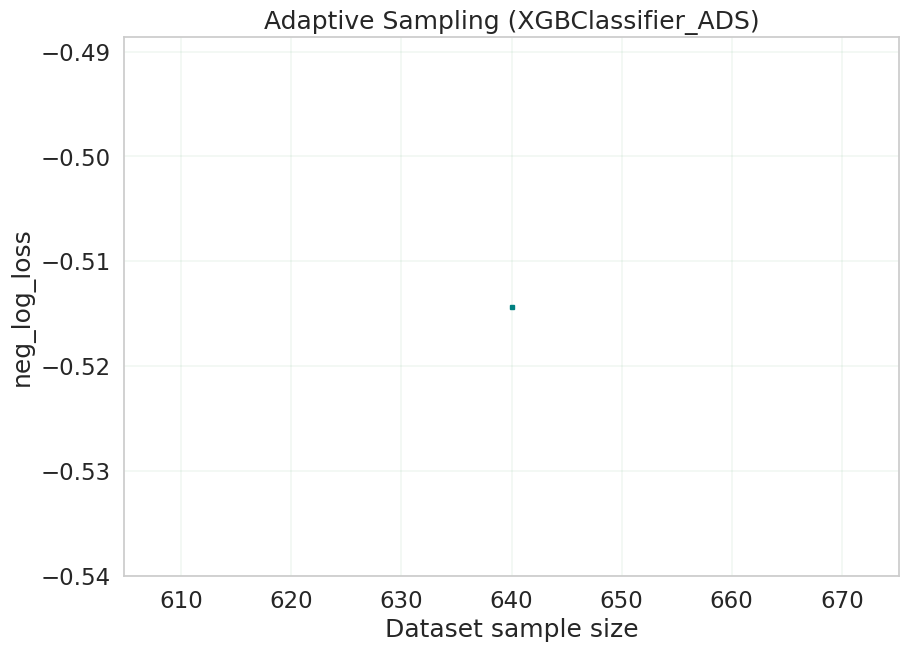

In [12]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = est.adaptive_sampling_trials_
scores = [x[3] for x in trials]
n_samples = [x[1] for x in trials]
y_margin = 0.10 * (max(scores) - min(scores))

fig, ax = plt.subplots(1)
ax.set_title("Adaptive Sampling ({})".format(trials[0][0]))
ax.set_xlabel('Dataset sample size')
ax.set_ylabel(est.inferred_score_metric[0])
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_samples, scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()

<a id='feature-selection'></a>
#### Feature Selection

After finding a sample subset, the next step is to find a relevant feature subset to maximize score for the chosen algorithm. AutoMLx Feature Selection follows an intelligent search strategy, looking at various possible feature rankings and subsets, and identifying that smallest feature subset that does not compromise on score for the chosen algorithm (`XGBClassifier`). The orange line shows the optimal number of features chosen by Feature Selection (in this case 19 features, droppping many other such as existing_credits, num_dependents and so on; see the output of the following cell for the complete list).

Features selected: ['checking_status_2', 'checking_status_3', 'checking_status_4', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status_2', 'personal_status_4', 'other_parties_2', 'residence_since', 'property_magnitude_4', 'age', 'other_payment_plans_2', 'housing_2', 'foreign_worker_2']
Features dropped: ['checking_status_1', 'personal_status_1', 'personal_status_3', 'other_parties_1', 'other_parties_3', 'property_magnitude_1', 'property_magnitude_2', 'property_magnitude_3', 'other_payment_plans_1', 'other_payment_plans_3', 'housing_1', 'housing_3', 'existing_credits', 'job_1', 'job_2', 'job_3', 'job_4', 'num_dependents', 'own_telephone_1', 'own_telephone_2', 'foreign_worker_1']


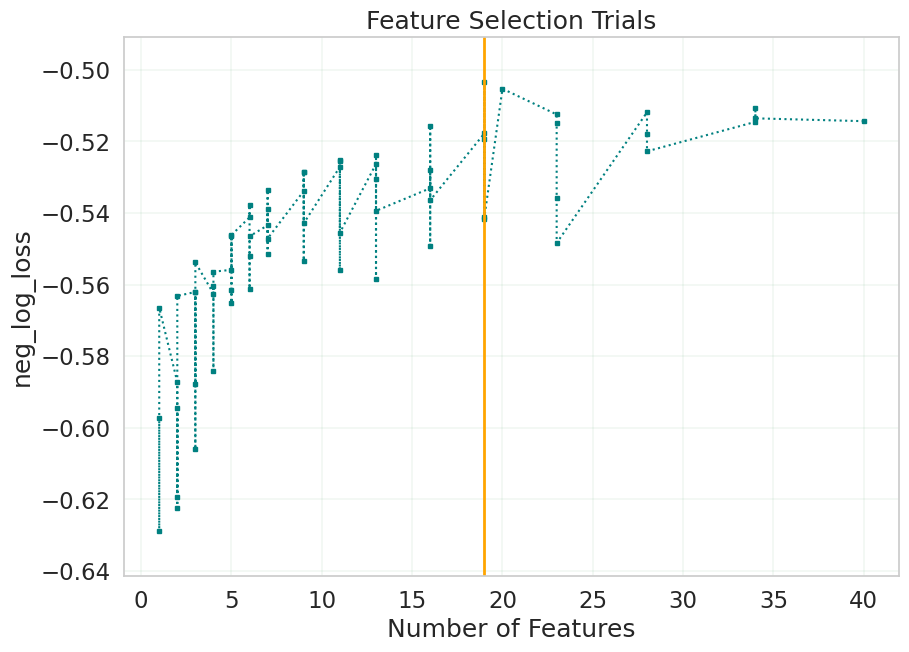

In [13]:
print(f"Features selected: {est.selected_features_names_.to_list()}")
dropped_features = est.pipeline.preprocessor.transformed_col_names.drop(est.selected_features_names_)
print(f"Features dropped: {dropped_features.to_list()}")

# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = est.feature_selection_trials_
scores = [x[3] for x in trials]
n_features = [x[2] for x in trials]
y_margin = 0.10 * (max(scores) - min(scores))


fig, ax = plt.subplots(1)
ax.set_title("Feature Selection Trials")
ax.set_xlabel("Number of Features")
ax.set_ylabel(est.inferred_score_metric[0])
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_features, scores, 'k:', marker="s", color='teal', markersize=3)
ax.axvline(x=len(est.selected_features_names_), color='orange', linewidth=2.0)
plt.show()

<a id='hyperparameter-tuning'></a>
#### Hyperparameter Tuning

Hyperparameter Tuning is the last stage of the AutoML pipeline, and focuses on improving the chosen algorithm's score on the reduced dataset (after Adaptive Sampling and Feature Selection). We use a novel algorithm to search across many hyperparameters dimensions, and converge automatically when optimal hyperparameters are identified. Each trial in the graph below represents a particular hyperparameters configuration for the selected model.

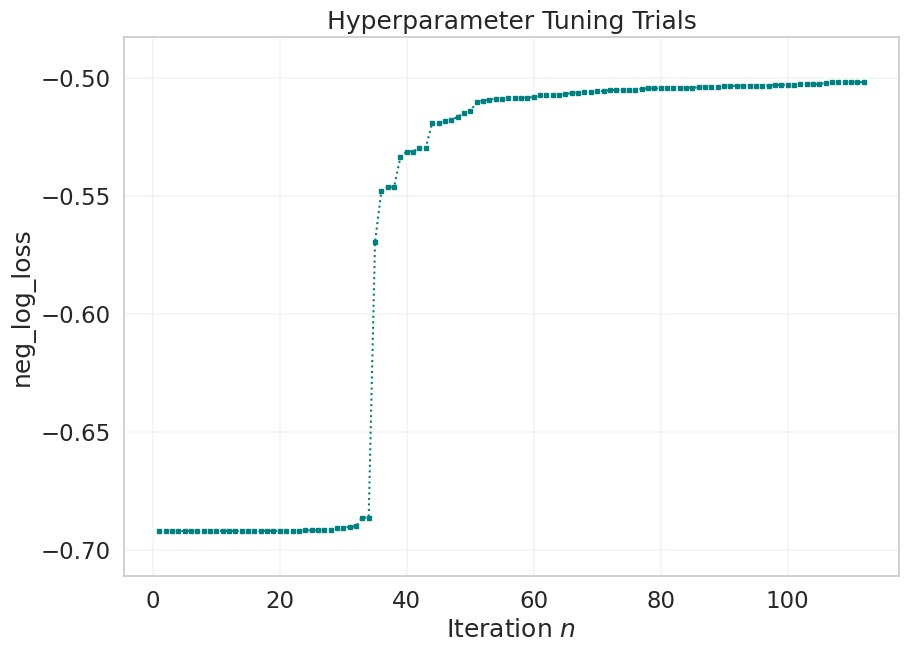

In [14]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = est.tuning_trials_
scores = [x[3] for x in reversed(trials)]
y_margin = 0.10 * (max(scores) - min(scores))


fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est.inferred_score_metric[0])
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(range(1, len(trials) + 1), scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()

Text(83.25, 0.5, 'Actual')

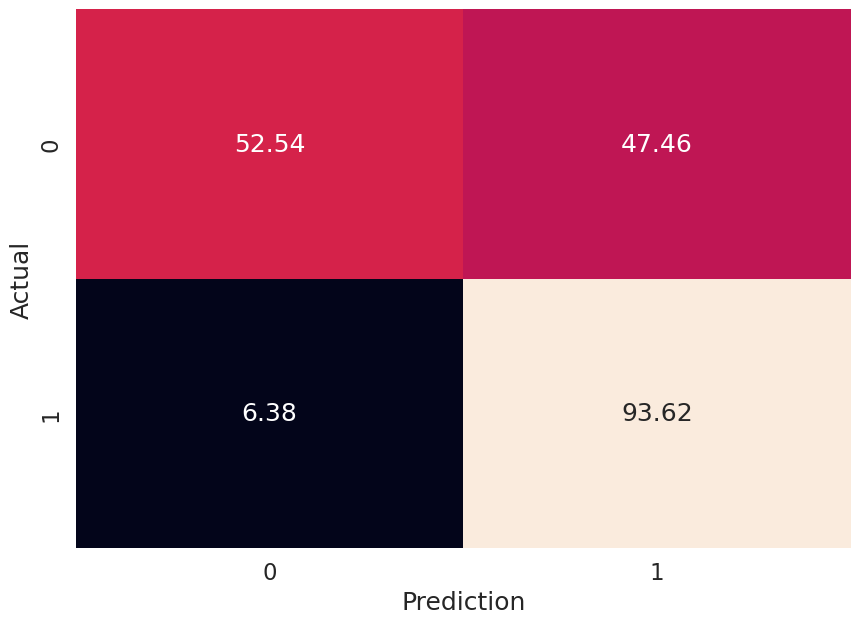

In [15]:
y_pred = est.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm)
df_cm = df_cm * 100

ax = sns.heatmap(df_cm, annot=True, fmt='.2f', cbar=False)
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

<a id='modellist'></a>
### Provide a specific model list to AutoML
The Oracle AutoMLx solution also supports a `model_list` argument, allowing you to control what algorithms AutoML considers during its optimization process. model_list is specified as a list of strings, which can be any combination of 

- AdaBoostClassifier
- DecisionTreeClassifier
- ExtraTreesClassifier
- TorchMLPClassifier
- KNeighborsClassifier
- LGBMClassifier
- LinearSVC
- LogisticRegression
- RandomForestClassifier
- SVC
- XGBClassifier
- GaussianNB

Here, we ask AutoML to only consider `LogisticRegression`. Note that it does not perform well compared to the full capabilites of the AutoML pipeline.

In [16]:
est2 = automl.Pipeline(model_list=['LogisticRegression'])
est2.fit(X_train, y_train)
y_pred = est2.predict(X_test)
score_default = f1_score(y_test, y_pred, average='macro')
print(f'Score on test data : {score_default}')

[2023-11-10 03:30:17,697] [automl.pipeline] Random state (7) is used for model builds
[2023-11-10 03:30:17,707] [automl.pipeline] Dataset shape: (800, 20)
[2023-11-10 03:30:17,714] [automl.pipeline] Running Auto-Preprocessing
[2023-11-10 03:30:17,788] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (800, 40), cv: 5
[2023-11-10 03:30:17,811] [automl.pipeline] Running Model Selection
[2023-11-10 03:30:17,812] [automl.pipeline] Algorithm Selection Disabled
[2023-11-10 03:30:17,813] [automl.pipeline] User provided model LogisticRegression is the only desired model
[2023-11-10 03:30:17,817] [automl.pipeline] Model Selection completed. Selected model: ['LogisticRegression']
[2023-11-10 03:30:17,818] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (800, 40), Valid Shape: None, CV: 5, Class counts: [241 559]
[2023-11-10 03:30:18,140] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (800, 40), Valid Shape: None, CV: [(640, 160), (640, 160), (64

In [17]:
est2 = automl.Pipeline(model_list=['RandomForestClassifier'])
est2.fit(X_train, y_train)
y_pred = est2.predict(X_test)
score_default = f1_score(y_test, y_pred, average='macro')
print(f'Score on test data : {score_default}')

[2023-11-10 03:30:35,104] [automl.pipeline] Random state (7) is used for model builds
[2023-11-10 03:30:35,117] [automl.pipeline] Dataset shape: (800, 20)
[2023-11-10 03:30:35,129] [automl.pipeline] Running Auto-Preprocessing
[2023-11-10 03:30:35,217] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (800, 40), cv: 5
[2023-11-10 03:30:35,241] [automl.pipeline] Running Model Selection
[2023-11-10 03:30:35,243] [automl.pipeline] Algorithm Selection Disabled
[2023-11-10 03:30:35,244] [automl.pipeline] User provided model RandomForestClassifier is the only desired model
[2023-11-10 03:30:35,253] [automl.pipeline] Model Selection completed. Selected model: ['RandomForestClassifier']
[2023-11-10 03:30:35,254] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (800, 40), Valid Shape: None, CV: 5, Class counts: [241 559]
[2023-11-10 03:30:39,164] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (800, 40), Valid Shape: None, CV: [(640, 160), (640, 1

<a id='custom-validation'></a>
### Use a custom validation set
You can specify a custom validation set that you want AutoML to use to evaluate the quality of models and configurations. 


In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=0)

In [19]:
est3 = automl.Pipeline()
est3.fit(X_train, y_train, X_val, y_val)

y_pred = est3.predict(X_test)
score_default = f1_score(y_test, y_pred, average='macro')
print(f'Score on test data : {score_default}')

[2023-11-10 03:32:07,077] [automl.pipeline] Random state (7) is used for model builds
[2023-11-10 03:32:07,092] [automl.pipeline] Dataset shape: (560, 20)
[2023-11-10 03:32:07,104] [automl.pipeline] Running Auto-Preprocessing
[2023-11-10 03:32:07,233] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (560, 40), cv: None
[2023-11-10 03:32:07,292] [automl.pipeline] Running Model Selection
[2023-11-10 03:32:11,051] [automl.pipeline] Model Selection completed. Selected model: ['SVC']
[2023-11-10 03:32:11,052] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (560, 40), Valid Shape: (240, 40), CV: None, Class counts: [167 393]
[2023-11-10 03:32:11,290] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (560, 40), Valid Shape: (240, 40), CV: None, Class counts: [167 393]
[2023-11-10 03:32:11,291] [automl.pipeline] Starting Feature Selection 0. Dataset Shape: (560, 40)
[2023-11-10 03:32:15,297] [automl.pipeline] Feature Selection 0 completed. Updat

<a id='nalgostuned'></a>
### Increase the number of tuned models
By default, we only optimize the hyper-parameters of the single best model from the model selection stage of our pipeline. However, you can also optimize the hyper-parameters of the top `n` models. In this example, we will tell the pipeline to tune the hyper-parameters for the best two of the three specified models. 

In [20]:
est4 = automl.Pipeline(n_algos_tuned=2, model_list=['SVC', 'RandomForestClassifier', 'XGBClassifier'])
est4.fit(X_train, y_train)

y_pred = est4.predict(X_test)
score_default = f1_score(y_test, y_pred, average='macro')
print(f'Score on test data : {score_default}')

[2023-11-10 03:32:18,551] [automl.pipeline] Random state (7) is used for model builds
[2023-11-10 03:32:18,563] [automl.pipeline] Dataset shape: (560, 20)
[2023-11-10 03:32:18,576] [automl.pipeline] Running Auto-Preprocessing
[2023-11-10 03:32:18,671] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (560, 40), cv: 5
[2023-11-10 03:32:18,716] [automl.pipeline] Running Model Selection
[2023-11-10 03:32:23,326] [automl.pipeline] Model Selection completed. Selected model: ['XGBClassifier', 'RandomForestClassifier']
[2023-11-10 03:32:23,327] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (560, 40), Valid Shape: None, CV: 5, Class counts: [167 393]
[2023-11-10 03:32:23,771] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (560, 40), Valid Shape: None, CV: [(448, 112), (448, 112), (448, 112), (448, 112), (448, 112)], Class counts: [167 393]
[2023-11-10 03:32:23,771] [automl.pipeline] Starting Feature Selection 0. Dataset Shape: (560, 40)
[202

<a id='scoringstr'></a>
### Specify a different scoring metric to AutoML
By default, the score metric is set to `neg_log_loss` for classifcation and `neg_mean_squared_error` for regression.

The user can also choose another scoring metric. The list of possible metrics is given by:
- For binary classification, one of 'roc_auc', 'accuracy', 'f1', 'precision', 'recall', 'f1_micro', 'f1_macro', 'f1_weighted', 'f1_samples', 'recall_micro', 'recall_macro', 'recall_weighted', 'recall_samples', 'precision_micro', 'precision_macro', 'precision_weighted', 'precision_samples'
- For multiclass classification , one of  'neg_log_loss', 'recall_macro', 'accuracy','f1_micro', 'f1_macro', 'f1_weighted', 'f1_samples', 'recall_micro', 'recall_weighted', 'recall_samples', 'precision_micro', 'precision_macro', 'precision_weighted', 'precision_samples'
- For regression, one of 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error'

Here, we ask AutoML to optimize for the `accuracy` scoring metric.

In [21]:
est5 = automl.Pipeline(score_metric='accuracy', model_list=['LogisticRegression'])
est5.fit(X_train, y_train)

y_pred = est5.predict(X_test)
score_default = f1_score(y_test, y_pred, average='macro')
print(f'Score on test data : {score_default}')

[2023-11-10 03:34:38,514] [automl.pipeline] Random state (7) is used for model builds
[2023-11-10 03:34:38,524] [automl.pipeline] Dataset shape: (560, 20)
[2023-11-10 03:34:38,532] [automl.pipeline] Running Auto-Preprocessing
[2023-11-10 03:34:38,606] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (560, 40), cv: 5
[2023-11-10 03:34:38,629] [automl.pipeline] Running Model Selection
[2023-11-10 03:34:38,630] [automl.pipeline] Algorithm Selection Disabled
[2023-11-10 03:34:38,630] [automl.pipeline] User provided model LogisticRegression is the only desired model
[2023-11-10 03:34:38,634] [automl.pipeline] Model Selection completed. Selected model: ['LogisticRegression']
[2023-11-10 03:34:38,635] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (560, 40), Valid Shape: None, CV: 5, Class counts: [167 393]
[2023-11-10 03:34:38,904] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (560, 40), Valid Shape: None, CV: [(448, 112), (448, 112), (44

<a id='scoringfn'></a>
### Specify a user defined scoring function to AutoML
Alternatively, the score_metric can also be specified as a user defined function of the form 
```
def score_fn(model, X, y):
    # logic here
    return score
```

Alternatively, the scoring function can be defined as
```
def score_fn(y_true, y_pred):
    # logic here
    return score
```
and then converted into the above format using scikit-learn's [make_scorer function.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer)

Here, we leverage scikit-learn's implementation of the `f1_score` function. We then create a scorer function (`score_fn`) and pass it to the `score_metric` argument of `train`.

In [22]:
# Define the scoring function
score_fn = make_scorer(f1_score, greater_is_better=True, needs_proba=False, average='macro')

est6 = automl.Pipeline(score_metric=score_fn, model_list=['LogisticRegression'])
est6.fit(X_train, y_train)

y_pred = est6.predict(X_test)
score_default = f1_score(y_test, y_pred, average='macro')
print(f'Score on test data : {score_default}')

[2023-11-10 03:34:55,241] [automl.pipeline] Random state (7) is used for model builds
[2023-11-10 03:34:55,250] [automl.pipeline] Dataset shape: (560, 20)
[2023-11-10 03:34:55,257] [automl.pipeline] Running Auto-Preprocessing
[2023-11-10 03:34:55,327] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (560, 40), cv: 5
[2023-11-10 03:34:55,349] [automl.pipeline] Running Model Selection
[2023-11-10 03:34:55,350] [automl.pipeline] Algorithm Selection Disabled
[2023-11-10 03:34:55,350] [automl.pipeline] User provided model LogisticRegression is the only desired model
[2023-11-10 03:34:55,354] [automl.pipeline] Model Selection completed. Selected model: ['LogisticRegression']
[2023-11-10 03:34:55,355] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (560, 40), Valid Shape: None, CV: 5, Class counts: [167 393]
[2023-11-10 03:34:55,617] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (560, 40), Valid Shape: None, CV: [(448, 112), (448, 112), (44

<a id='timebudget'></a>
### Specify a time budget to AutoML
The Oracle AutoMLx tool also supports a user given time budget in seconds. Given the small size of this dataset, we give a small time budget of 10 seconds using the `time_budget` argument.

In [23]:
est7 = automl.Pipeline()
est7.fit(X_train, y_train, time_budget=10)

y_pred = est7.predict(X_test)
score_default = f1_score(y_test, y_pred, average='macro')
print(f'Score on test data : {score_default}')

[2023-11-10 03:35:09,686] [automl.pipeline] Random state (7) is used for model builds
[2023-11-10 03:35:09,699] [automl.pipeline] Dataset shape: (560, 20)
[2023-11-10 03:35:09,711] [automl.pipeline] Running Auto-Preprocessing
[2023-11-10 03:35:09,788] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (560, 40), cv: 5
[2023-11-10 03:35:09,819] [automl.pipeline] Running Model Selection
[2023-11-10 03:35:16,846] [automl.pipeline] Model Selection completed. Selected model: ['XGBClassifier']
[2023-11-10 03:35:16,847] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (560, 40), Valid Shape: None, CV: 5, Class counts: [167 393]
[2023-11-10 03:35:17,291] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (560, 40), Valid Shape: None, CV: [(448, 112), (448, 112), (448, 112), (448, 112), (448, 112)], Class counts: [167 393]
[2023-11-10 03:35:17,292] [automl.pipeline] Starting Feature Selection 0. Dataset Shape: (560, 40)
[2023-11-10 03:35:21,385] [aut

<a id='minfeatures'></a>
### Specify a minimum feature list to AutoML
The Oracle AutoMLx Pipeline also supports a `min_features` argument. AutoML will ensure that these features are part of the final model that it creates, and these are not dropped during the feature selection phase.
It can take 3 possible types of values: 
- If int, 0 < min_features <= n_features, 
- If float, 0 < min_features <= 1.0, 1.0 means disabling feature selection
- If list, names of features to keep, for example ['a', 'b'] means keep features 'a' and 'b'

In [24]:
est8 = automl.Pipeline(min_features=['num_dependents', 'existing_credits'],  model_list=['LogisticRegression'])
est8.fit(X_train, y_train)
y_pred = est8.predict(X_test)
score_default = f1_score(y_test, y_pred, average='macro')
print(f'Score on test data : {score_default}')
print(f'Selected features: {est8.selected_features_names_}')

[2023-11-10 03:36:24,733] [automl.pipeline] Random state (7) is used for model builds
[2023-11-10 03:36:24,743] [automl.pipeline] Dataset shape: (560, 20)
[2023-11-10 03:36:24,753] [automl.pipeline] Running Auto-Preprocessing
[2023-11-10 03:36:24,824] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (560, 40), cv: 5
[2023-11-10 03:36:24,850] [automl.pipeline] Running Model Selection
[2023-11-10 03:36:24,851] [automl.pipeline] Algorithm Selection Disabled
[2023-11-10 03:36:24,852] [automl.pipeline] User provided model LogisticRegression is the only desired model
[2023-11-10 03:36:24,859] [automl.pipeline] Model Selection completed. Selected model: ['LogisticRegression']
[2023-11-10 03:36:24,860] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (560, 40), Valid Shape: None, CV: 5, Class counts: [167 393]
[2023-11-10 03:36:25,174] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (560, 40), Valid Shape: None, CV: [(448, 112), (448, 112), (44